# Lab 1 _Poisson Regression

Try to use both `SK_learn` and `statmodels` libraries.

A data set of counts has the following characteristics:

1. Whole number data: The data consists of non-negative integers: [0… ∞] Regression techniques such as Ordinary Least Squares Regression may not be appropriate for modeling such data as OLSR works best on real numbers such as -656.0, -0.00000345, 13786.1 etc.
2. Skewed Distribution: The data may contain a large number of data points for just a few values, thereby making the frequency distribution quite skewed. See for example above histogram.
3. Sparsity: The data may reflect the occurrence of a rare event such as a gamma ray burst, thereby making the data sparse.
4. Rate of occurrence: For the sake of creating a model, it can be assumed that there is a certain rate of occurrence of events λ that drives the generation of such data. The event rate may drift over time.

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (11, 5)  #set default figure size
import numpy as np
from numpy import exp
from scipy.special import factorial
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from scipy import stats
from scipy.stats import norm


/var/folders/29/wq14mrc56b72ty43ycw_32yr0000gn/T/ipykernel_82160/1782538796.py:7: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
import statsmodels.api as sm
from statsmodels.api import Poisson
from statsmodels.iolib.summary2 import summary_col
from sklearn.linear_model import PoissonRegressor

In [4]:
import random
import math

In [5]:
from patsy import dmatrices

## Time Series Analysis, Regression and Forecasting 

### Example

Here, we use the cleaned data. The raw data are avilable here: https://data.cityofnewyork.us/Transportation/Bicycle-Counters/smn3-rzf9

In [6]:
df = pd.read_csv('nyc_bb_bicyclist_counts.csv', header=0, parse_dates=[0], index_col=[0])
df

/var/folders/29/wq14mrc56b72ty43ycw_32yr0000gn/T/ipykernel_82160/547433981.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv('nyc_bb_bicyclist_counts.csv', header=0, parse_dates=[0], index_col=[0])


,HIGH_T,LOW_T,PRECIP,BB_COUNT
Date,,,,
2017-04-01,46.0,37.0,0.00,606
2017-04-02,62.1,41.0,0.00,2021
2017-04-03,63.0,50.0,0.03,2470
2017-04-04,51.1,46.0,1.18,723
2017-04-05,63.0,46.0,0.00,2807
...,...,...,...,...
2017-10-27,62.1,48.0,0.00,3150
2017-10-28,68.0,55.9,0.00,2245
2017-10-29,64.9,61.0,3.03,183


We’ll add a few derived regression variables to the X matrix.

In [7]:
ds = df.index.to_series()
df['MONTH'] = ds.dt.month
df['DAY_OF_WEEK'] = ds.dt.dayofweek
df['DAY'] = ds.dt.day

In [8]:
df

,HIGH_T,LOW_T,PRECIP,BB_COUNT,MONTH,DAY_OF_WEEK,DAY
Date,,,,,,,
2017-04-01,46.0,37.0,0.00,606,4,5,1
2017-04-02,62.1,41.0,0.00,2021,4,6,2
2017-04-03,63.0,50.0,0.03,2470,4,0,3
2017-04-04,51.1,46.0,1.18,723,4,1,4
2017-04-05,63.0,46.0,0.00,2807,4,2,5
...,...,...,...,...,...,...,...
2017-10-27,62.1,48.0,0.00,3150,10,4,27
2017-10-28,68.0,55.9,0.00,2245,10,5,28
2017-10-29,64.9,61.0,3.03,183,10,6,29


We will not use the Date variable as a regressor since it contains an absolute date value but we don’t need to do anything special to drop Date as it is already consumed as the index of the pandas DataFrame. So it will not be available to us in the X matrix.

Let’s create the training and testing data sets.

In [9]:
mask = np.random.rand(len(df)) < 0.8
df_train = df[mask]
df_test = df[~mask]
print('Training data set length='+str(len(df_train)))
print('Testing data set length='+str(len(df_test)))

Training data set length=171
Testing data set length=43


Setup the regression expression in patsy notation. We are telling patsy that BB_COUNT is our dependent variable and it depends on the regression variables: DAY, DAY_OF_WEEK, MONTH, HIGH_T, LOW_T and PRECIP.

In [10]:
expr = """BB_COUNT ~ DAY  + DAY_OF_WEEK + MONTH + HIGH_T + LOW_T + PRECIP"""

Set up the X and y matrices for the training and testing data sets. patsy makes this really simple.

In [11]:
y_train, X_train = dmatrices(expr, df_train, return_type='dataframe')
y_test, X_test = dmatrices(expr, df_test, return_type='dataframe')

Using the statsmodels GLM class, train the Poisson regression model on the training data set.

In [12]:
poisson_training_results = sm.GLM(y_train, X_train, family=sm.families.Poisson()).fit()

Print the training summary.

In [13]:
print(poisson_training_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:               BB_COUNT   No. Observations:                  171
Model:                            GLM   Df Residuals:                      164
Model Family:                 Poisson   Df Model:                            6
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -12351.
Date:                Fri, 09 Feb 2024   Deviance:                       23051.
Time:                        16:54:58   Pearson chi2:                 2.32e+04
No. Iterations:                     6   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       7.1010      0.013    565.188      

The summary() method on the statsmodels GLMResults class shows a couple of useful goodness-of-fit statistics to help you evaluate whether your Poisson regression model was able to successfully fit the training data. (e.g., Deviance, Pearson Chi2)

The low performance of the model was because the data did not obey the variance = mean criterion required of it by the Poisson regression model. (Negative Binomial model is another choice)

This rather strict criterion is often not satisfied by real world data. Often, the variance is greater than the mean, a property called over-dispersion, and sometimes the variance is less than the mean, called under-dispersion. In such cases, one needs to use a regression model that will not make the equi-dispersion assumption i.e.not assume that variance=mean.

### So how well did our model do? Let’s make some predictions on the test data set.

In [14]:
poisson_predictions = poisson_training_results.get_prediction(X_test)
#summary_frame() returns a pandas DataFrame
predictions_summary_frame = poisson_predictions.summary_frame()
print(predictions_summary_frame)

                   mean    mean_se  mean_ci_lower  mean_ci_upper
Date                                                            
2017-04-01  1965.724733  11.781978    1942.767589    1988.953155
2017-04-02  2691.748187  15.005199    2662.498617    2721.319086
2017-04-03  2599.169738  11.382450    2576.956015    2621.574947
2017-04-15  2474.496742   9.004302    2456.911418    2492.207933
2017-04-23  2651.927725  12.573380    2627.398501    2676.685953
2017-04-26  1682.455349   7.805395    1667.226398    1697.823406
2017-04-27  2491.772465   9.672321    2472.886994    2510.802163
2017-04-28  3600.468639  19.788877    3561.891309    3639.463783
2017-05-03  2387.253654   9.720235    2368.278160    2406.381187
2017-05-13   703.155488   7.080374     689.414252     717.170611
2017-05-19  3215.484351  11.681116    3192.671097    3238.460618
2017-05-21  2464.887460   9.218089    2446.886391    2483.020958
2017-05-27  2535.149668   9.490028    2516.617623    2553.818181
2017-05-28  2571.998490  

Each row: The first column is the date. The second column is the prediciton fo the mean. The third column is the standard error for the mean. The last two columns are teh 95% confidence interval.

Let’s plot the predicted counts versus the actual counts for the test data.

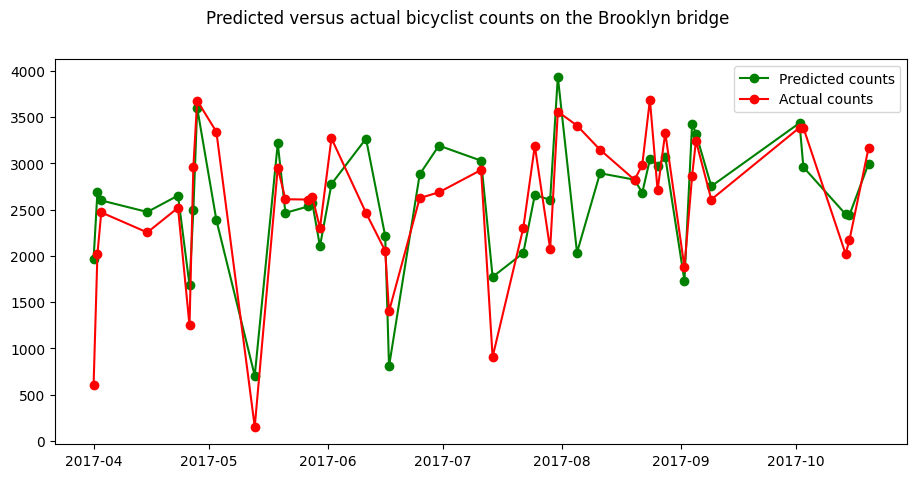

In [15]:
predicted_counts=predictions_summary_frame['mean']
actual_counts = y_test['BB_COUNT']
fig = plt.figure()
fig.suptitle('Predicted versus actual bicyclist counts on the Brooklyn bridge')
predicted, = plt.plot(X_test.index, predicted_counts, 'go-', label='Predicted counts')
actual, = plt.plot(X_test.index, actual_counts, 'ro-', label='Actual counts')
plt.legend(handles=[predicted, actual])
plt.show()

The model seems to be more or less tracking the trend in the actual counts although in many cases its predictions are way off the actual value.

Let’s also plot Actual versus Predicted counts.

<Figure size 1100x500 with 0 Axes>

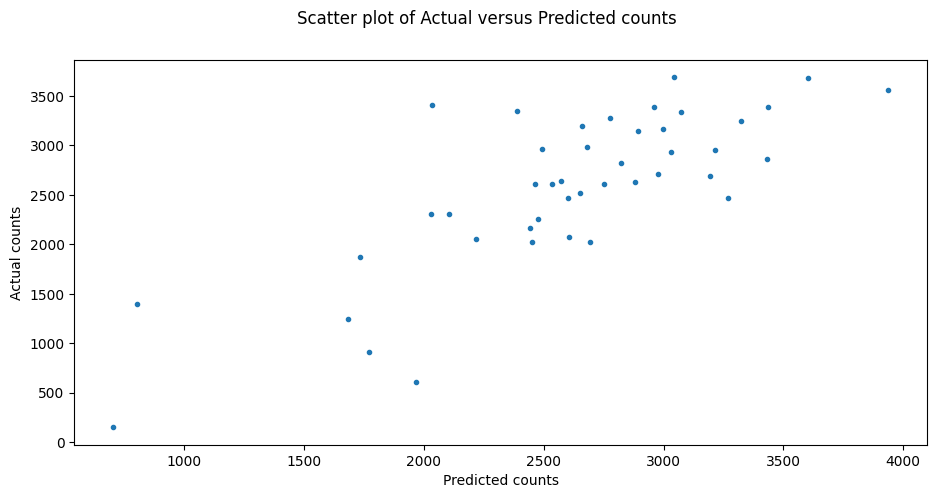

In [16]:
plt.clf()
fig = plt.figure()
fig.suptitle('Scatter plot of Actual versus Predicted counts')
plt.scatter(x=predicted_counts, y=actual_counts, marker='.')
plt.xlabel('Predicted counts')
plt.ylabel('Actual counts')
plt.show()

# Traffic Accident Data Set:

Data Sets: 

1. US Accidents (2016 - 2021)

A Countrywide Traffic Accident Dataset (2016 - 2021)

https://www.kaggle.com/datasets/sobhanmoosavi/us-accidents?select=US_Accidents_Dec21_updated.csv  (Data is 1.2G)

Feature information: US-Accidents: A Countrywide Traffic Accident Dataset Description: 
https://smoosavi.org/datasets/us_accidents


2. Accidents in France from 2005 to 2016 (for yourself in future study)

https://www.kaggle.com/datasets/ahmedlahlou/accidents-in-france-from-2005-to-2016 

# Questions:  

#### 1. Use US Accidents (2016 - 2021) data, summerize by daily, use Temperature(F), Precipitation(in), Wind_Speed(mph), humidity (in percentage).  

#### 2. Use Possion regression to model the daily accident in the US (or in one state data, or one city data, or only use 1 year data, if your computer is not powerful enough ) 

#### or 3, You can also summerize your own question, but you need to use possion regression to model the data

Kaggle has several good notebooks in python: 
For example, https://www.kaggle.com/datasets/sobhanmoosavi/us-accidents/code?select=US_Accidents_Dec21_updated.csv and find in `Code`

One example for Cleveland, OH.
https://www.kaggle.com/code/sekoukeita/analysis-and-visualization-for-us-and-cleveland-oh


#### or 4. If you feel difficult of dealing with the raw data above, you can start with a similar example from below:
Daily total of bike counts conducted monthly on the Brooklyn Bridge, Manhattan Bridge, Williamsburg Bridge, and Queensboro Bridge.
https://data.cityofnewyork.us/Transportation/Bicycle-Counts-for-East-River-Bridges-Historical-/gua4-p9wg 

In [17]:
df = pd.read_csv('US_Accidents_March23_sampled_500k.csv', header=0, parse_dates=[0], index_col=[0])
df

/var/folders/29/wq14mrc56b72ty43ycw_32yr0000gn/T/ipykernel_82160/153546503.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv('US_Accidents_March23_sampled_500k.csv', header=0, parse_dates=[0], index_col=[0])


,Source,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Description,...,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
ID,,,,,,,,,,,,,,,,,,,,,
A-2047758,Source2,2,2019-06-12 10:10:56,2019-06-12 10:55:58,30.641211,-91.153481,NaN,NaN,0.000,Accident on LA-19 Baker-Zachary Hwy at Lower Z...,...,False,False,False,False,True,False,Day,Day,Day,Day
A-4694324,Source1,2,2022-12-03 23:37:14.000000000,2022-12-04 01:56:53.000000000,38.990562,-77.399070,38.990037,-77.398282,0.056,Incident on FOREST RIDGE DR near PEPPERIDGE PL...,...,False,False,False,False,False,False,Night,Night,Night,Night
A-5006183,Source1,2,2022-08-20 13:13:00.000000000,2022-08-20 15:22:45.000000000,34.661189,-120.492822,34.661189,-120.492442,0.022,Accident on W Central Ave from Floradale Ave t...,...,False,False,False,False,True,False,Day,Day,Day,Day
A-4237356,Source1,2,2022-02-21 17:43:04,2022-02-21 19:43:23,43.680592,-92.993317,43.680574,-92.972223,1.054,Incident on I-90 EB near REST AREA Drive with ...,...,False,False,False,False,False,False,Day,Day,Day,Day
A-6690583,Source1,2,2020-12-04 01:46:00,2020-12-04 04:13:09,35.395484,-118.985176,35.395476,-118.985995,0.046,RP ADV THEY LOCATED SUSP VEH OF 20002 - 726 CR...,...,False,False,False,False,False,False,Night,Night,Night,Night
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
A-6077227,Source1,2,2021-12-15 07:30:00,2021-12-15 07:50:30,45.522510,-123.084104,45.520225,-123.084211,0.158,Stationary traffic on OR-47 from NW Martin Rd ...,...,False,False,False,False,False,False,Night,Day,Day,Day
A-6323243,Source1,2,2021-12-19 16:25:00,2021-12-19 17:40:37,26.702570,-80.111169,26.703141,-80.111133,0.040,Incident on MILITARY TRL near WESTGATE AVE Dri...,...,False,False,False,False,False,False,Day,Day,Day,Day
A-3789256,Source1,2,2022-04-13 19:28:29,2022-04-13 21:33:44,34.561862,-112.259620,34.566822,-112.267150,0.549,Crash on the right shoulder on E SR-69 Northbo...,...,False,False,False,False,True,False,Night,Night,Day,Day


In [19]:
city_counts = df['City'].value_counts()

In [20]:
print(city_counts)

City
Miami            12141
Houston          11031
Los Angeles      10299
Charlotte         8979
Dallas            8245
                 ...  
Newcomerstown        1
Lakehurst            1
New Concord          1
Smithmill            1
Fair Haven           1
Name: count, Length: 9488, dtype: int64


In [17]:
df['Start_Time'] = pd.to_datetime(df['Start_Time'], format = 'mixed')
df['Date'] = df['Start_Time'].dt.date


# Create a Series from the 'Start_Time' column
ds = df['Start_Time']
daily_accidents = df.groupby('Date').size().reset_index(name='Accident_Count')

df_daily = df.merge(daily_accidents, on='Date', how='left')

# Extract month, day of the week, and day, and create new columns
df_daily['DAY'] = df_daily['Start_Time'].dt.day
df_daily['DAY_OF_WEEK'] = df_daily['Start_Time'].dt.dayofweek
df_daily['MONTH'] = df_daily['Start_Time'].dt.month

In [26]:
df_daily

,Source,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Description,...,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight,Date,Accident_Count,DAY,DAY_OF_WEEK,MONTH
0,Source2,2,2019-06-12 10:10:56,2019-06-12 10:55:58,30.641211,-91.153481,NaN,NaN,0.000,Accident on LA-19 Baker-Zachary Hwy at Lower Z...,...,False,Day,Day,Day,Day,2019-06-12,188,12,2,6
1,Source1,2,2022-12-03 23:37:14,2022-12-04 01:56:53.000000000,38.990562,-77.399070,38.990037,-77.398282,0.056,Incident on FOREST RIDGE DR near PEPPERIDGE PL...,...,False,Night,Night,Night,Night,2022-12-03,274,3,5,12
2,Source1,2,2022-08-20 13:13:00,2022-08-20 15:22:45.000000000,34.661189,-120.492822,34.661189,-120.492442,0.022,Accident on W Central Ave from Floradale Ave t...,...,False,Day,Day,Day,Day,2022-08-20,255,20,5,8
3,Source1,2,2022-02-21 17:43:04,2022-02-21 19:43:23,43.680592,-92.993317,43.680574,-92.972223,1.054,Incident on I-90 EB near REST AREA Drive with ...,...,False,Day,Day,Day,Day,2022-02-21,296,21,0,2
4,Source1,2,2020-12-04 01:46:00,2020-12-04 04:13:09,35.395484,-118.985176,35.395476,-118.985995,0.046,RP ADV THEY LOCATED SUSP VEH OF 20002 - 726 CR...,...,False,Night,Night,Night,Night,2020-12-04,95,4,4,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499995,Source1,2,2021-12-15 07:30:00,2021-12-15 07:50:30,45.522510,-123.084104,45.520225,-123.084211,0.158,Stationary traffic on OR-47 from NW Martin Rd ...,...,False,Night,Day,Day,Day,2021-12-15,462,15,2,12
499996,Source1,2,2021-12-19 16:25:00,2021-12-19 17:40:37,26.702570,-80.111169,26.703141,-80.111133,0.040,Incident on MILITARY TRL near WESTGATE AVE Dri...,...,False,Day,Day,Day,Day,2021-12-19,178,19,6,12
499997,Source1,2,2022-04-13 19:28:29,2022-04-13 21:33:44,34.561862,-112.259620,34.566822,-112.267150,0.549,Crash on the right shoulder on E SR-69 Northbo...,...,False,Night,Night,Day,Day,2022-04-13,522,13,2,4
499998,Source1,3,2020-05-15 17:20:56,2020-05-15 17:50:56,38.406680,-78.619310,38.406680,-78.619310,0.000,At US-340/S Stuart Ave - Serious accident.,...,False,Day,Day,Day,Day,2020-05-15,247,15,4,5


In [22]:
# Get the column headers as an Index object
column_headers = df_daily.columns

# Convert the column headers to a list, if needed
column_headers_list = column_headers.tolist()

# Print the list of column headers
print(column_headers_list)

['Source', 'Severity', 'Start_Time', 'End_Time', 'Start_Lat', 'Start_Lng', 'End_Lat', 'End_Lng', 'Distance(mi)', 'Description', 'Street', 'City', 'County', 'State', 'Zipcode', 'Country', 'Timezone', 'Airport_Code', 'Weather_Timestamp', 'Temperature(F)', 'Wind_Chill(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Direction', 'Wind_Speed(mph)', 'Precipitation(in)', 'Weather_Condition', 'Amenity', 'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop', 'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight', 'Astronomical_Twilight', 'Date', 'Accident_Count', 'DAY', 'DAY_OF_WEEK', 'MONTH']


In [39]:
# Define the columns to keep
columns_to_keep = ["Severity", "City", "Temperature(F)", "Humidity(%)", "Wind_Speed(mph)", "Precipitation(in)", 'MONTH', 'DAY_OF_WEEK', 'DAY', 'Accident_Count', 'Date']

# Subset the DataFrame to keep only the specified columns
df_subset = df_daily[columns_to_keep]

In [40]:
df_subset

,Severity,City,Temperature(F),Humidity(%),Wind_Speed(mph),Precipitation(in),MONTH,DAY_OF_WEEK,DAY,Accident_Count,Date
0,2,Zachary,77.0,62.0,5.0,0.00,6,2,12,188,2019-06-12
1,2,Sterling,45.0,48.0,5.0,0.00,12,5,3,274,2022-12-03
2,2,Lompoc,68.0,73.0,13.0,0.00,8,5,20,255,2022-08-20
3,2,Austin,27.0,86.0,15.0,0.00,2,0,21,296,2022-02-21
4,2,Bakersfield,42.0,34.0,0.0,0.00,12,4,4,95,2020-12-04
...,...,...,...,...,...,...,...,...,...,...,...
499995,2,Forest Grove,40.0,77.0,15.0,0.01,12,2,15,462,2021-12-15
499996,2,West Palm Beach,78.0,87.0,13.0,0.01,12,6,19,178,2021-12-19
499997,2,Dewey,52.0,12.0,12.0,0.00,4,2,13,522,2022-04-13
499998,3,Elkton,82.0,38.0,14.0,0.00,5,4,15,247,2020-05-15


In [41]:
set(df['Severity'])

{1, 2, 3, 4}

In [38]:
df_subset[(df_subset['Date'] == df_subset['Date'][1]) & (df_subset['City'] == df_subset['City'][1])]

,City,Temperature(F),Humidity(%),Wind_Speed(mph),Precipitation(in),MONTH,DAY_OF_WEEK,DAY,Accident_Count,Date
1,Sterling,45.0,48.0,5.0,0.0,12,5,3,274,2022-12-03
20019,Sterling,61.0,72.0,13.0,0.0,12,5,3,274,2022-12-03
494243,Sterling,60.0,55.0,9.0,0.0,12,5,3,274,2022-12-03


In [43]:
summary = df_subset.describe()
print(summary)

       Temperature(F)    Humidity(%)  Wind_Speed(mph)  Precipitation(in)  \
count   489534.000000  488870.000000    463013.000000      357384.000000   
mean        61.646254      64.834921         7.681347           0.008289   
std         19.000133      22.826158         5.431361           0.101865   
min        -77.800000       1.000000         0.000000           0.000000   
25%         49.000000      48.000000         4.600000           0.000000   
50%         64.000000      67.000000         7.000000           0.000000   
75%         76.000000      84.000000        10.400000           0.000000   
max        207.000000     100.000000       822.800000          10.130000   

               MONTH    DAY_OF_WEEK            DAY  
count  500000.000000  500000.000000  500000.000000  
mean        6.702528       2.594916      15.742054  
std         3.639946       1.804955       8.674241  
min         1.000000       0.000000       1.000000  
25%         3.000000       1.000000       8.000000

In [46]:
mask = np.random.rand(len(df_subset)) < 0.8
df_train = df_subset[mask]
df_test = df_subset[~mask]
print('Training data set length = ' + str(len(df_train)))
print('Testing data set length = ' + str(len(df_test)))

Training data set length = 399838
Testing data set length = 100162


In [58]:
expr = 'BB_COUNT ~ DAY + DAY_OF_WEEK + MONTH + Q("Temperature(F)") + Q("Humidity(%)") + Wind_Speed(mph) + Q("Precipitation(in)")'

In [59]:
y_train, X_train = dmatrices(expr, df_train, return_type = 'dataframe')
y_test, X_test = dmatrices(expr, df_test, return_type = 'dataframe')

PatsyError: Error evaluating factor: NameError: name 'BB_COUNT' is not defined
    BB_COUNT ~ DAY + DAY_OF_WEEK + MONTH + Q("Temperature(F)") + Q("Humidity(%)") + Wind_Speed(mph) + Q("Precipitation(in)")
    ^^^^^^^^